In [1]:
import sys
import os
import copy
import traceback
import numpy as np

sys.path.append('../qslam')

from singlerun import SingleRunAnalysis
from riskanalysis import EngineeredTruth
from qslamdesignparams import GLOBALDICT
from visualiserisk import *

In [2]:
idx_prefix = 4
linear=False
if idx_prefix ==0:
    linear = True
# truth flag type (five options)
# 0 - Linear 1D field, 25 qubit array
# 1 - Square 2D field, 25 qubit array
# 2 - Gaussian 2D array, 25 qubit array
# 3 - Square 2D field, 9 qubit array
# 4 - Square 2D field, 16 qubit array



In [3]:
########################
# Truth Parameters
########################

# Choose defaults to match floor case (heights didn't work)
TRUTHKWARGS = {}

BARRIER_FLOOR = 0.25*np.pi
BARRIER_HEIGHT = 0.75*np.pi
FLOOR_RATIO = 0.4 # matches floor case

TRUTHKWARGS["OneStepdheight"] = {"low": BARRIER_FLOOR, 
                                 "high": BARRIER_HEIGHT} 
TRUTHKWARGS["OneStepdfloorarea"] = FLOOR_RATIO 


########################
# Save to path 
########################

path = '/scratch/QCL_RG/qslamdatapaper_v3/' # on Artemis
# path = './data_ALPHA_test/'

########################
# Set true field
########################

if idx_prefix == 0:
    change_gridconfig = True # 1D
    TRUTHFLAG = None # use TRUTHKWARGS
    TRUTHKWARGS["truthtype"] = 'OneStepd' 

if idx_prefix == 1: 
    change_gridconfig = False # 2D
    TRUTHFLAG = None # use TRUTHKWARGS
    TRUTHKWARGS["truthtype"] = 'OneStepq' 

if idx_prefix == 2:
    change_gridconfig = False # 2D
    TRUTHFLAG = None # use TRUTHKWARGS
    TRUTHKWARGS["truthtype"] = 'Gaussian' 
    
if idx_prefix > 2: # Covers all truth flag options except 2.
    change_gridconfig = False # 2D
    TRUTHFLAG = None # use TRUTHKWARGS
    TRUTHKWARGS["truthtype"] = 'OneStepq' 

########################
# Set 1D Hardware if req
########################

num_of_nodes = len(GLOBALDICT["GRIDDICT"])

if change_gridconfig is True:
    
    GLOBALDICT["GRIDDICT"] = {}
    
    for idx_posy in range(num_of_nodes):
        
        if idx_posy < 10 :
            
            GLOBALDICT["GRIDDICT"]["QUBIT_0" + str(idx_posy)] = (0.0, float(idx_posy))
            
        if idx_posy >= 10 :
            
            GLOBALDICT["GRIDDICT"]["QUBIT_" + str(idx_posy)] = (0.0, float(idx_posy))

########################
# Change 2D Grid Size if req
########################

if idx_prefix == 3:
    from qslamdesignparams import GRIDDICT_9
    GLOBALDICT["GRIDDICT"] = copy.deepcopy(GRIDDICT_9)
    num_of_nodes = len(GLOBALDICT["GRIDDICT"])

if idx_prefix == 4:
    from qslamdesignparams import GRIDDICT_16
    GLOBALDICT["GRIDDICT"] = copy.deepcopy(GRIDDICT_16)
    num_of_nodes = len(GLOBALDICT["GRIDDICT"])

########################
# Set Defaults
########################

GLOBALDICT["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = 75
GLOBALDICT["MODELDESIGN"]["MSMTS_PER_NODE"] = 1
GLOBALDICT["MODELDESIGN"]["MULTIPLER_R_MAX"] = 4.

repts = 50
particleconfigs = [ [3,2], [9,6], [15,10], [21,14], [30, 20]]

prefix = '_idx_prefix_'+str(idx_prefix)+'_'
lambda_paris_2 = np.load('lambda_pairs_2.npz')
random_variances = np.load('random_variances.npz')

IDX1_SHP = len(random_variances['g1var'])
IDX2_SHP = 30 # len(lambda_paris_2['lambda_1']) not doing all 250
IDX3_SHP = len(particleconfigs)



########################
# Run Script
########################

truemap_generator = EngineeredTruth(num_of_nodes, TRUTHKWARGS)
true_map_ = truemap_generator.get_map()


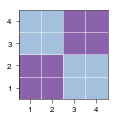

In [4]:
gslayout = gs(3, 4, top = 0.95, bottom =0.05, left = 0.05, right = 0.95, wspace = 0.05, hspace = 0.08)

fig = plt.figure(figsize=(cm2inch(16),cm2inch(11)))
ax = fig.add_subplot(gslayout[0,0])

if linear is False:
    
    if true_map_.shape[0] < 4:
        mapdata = true_map_[np.newaxis, :]
        cax = ax.imshow(mapdata, **HEATMAP)
    if true_map_.shape[0] >= 4:
        mapdims = int(np.sqrt(true_map_.shape))
        mapdata = true_map_.reshape(mapdims, mapdims)
        cax = ax.imshow(mapdata, **HEATMAP)

if linear is True:
    mapdata = true_map_[np.newaxis, :]
    cax = ax.imshow(mapdata, **HEATMAP)
    ax.set_aspect(7)
# Show all ticks...
ax.set_xticks(np.arange(mapdata.shape[1]), minor=True)
ax.set_yticks(np.arange(mapdata.shape[0]), minor=True)

# Get rid of bounding box
# for edge, spine in ax.spines.items():
#    spine.set_visible(False)

# Make a grid and put labels on the center
axis_list = [ax.yaxis, ax.xaxis]
for idx_axis in range(2):

    labels = range(1, mapdata.shape[idx_axis] + 1, 1)
    locs = np.arange(len(labels))

    axis = axis_list[idx_axis]
    axis.set_ticks(locs + 0.5, minor=True)

    if linear == True:
        locs = locs[4::5]
        labels = labels[4::5]

    axis.set(ticks=locs, ticklabels=labels)

# Make the grid white
ax.grid(which="minor", color="w", linestyle='-', linewidth=GRIDLW)
ax.tick_params(axis='both', which='both', color='w')
ax.tick_params(axis='both', which='major', color='k', direction='out')

plt.savefig('truemap_prefix_'+str(idx_prefix), format='svg', dpi=400)

plt.show()